In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import xarray as xr
import xskillscore as xs
import requests
import shapely.geometry as sgeom
from matplotlib.patches import Rectangle

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


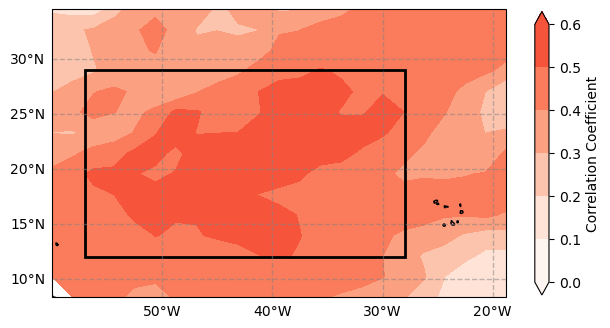

In [16]:
# 2mT data
# all_tas = xr.open_dataset('/work/uo1075/u301680/tas_data/data_reserve/tas_1850_2014.nc')
all_tas = xr.open_dataset("/work/uo1075/u301680/tas_data/data_reserve/tas_europe.nc")

# tos data
# all_tos = xr.open_dataset("/work/uo1075/u301680/tos_data/tos_omon_merge.nc")
# tos data after regriding
all_tos = xr.open_dataset('/work/uo1075/u301680/tos_data/tos_regrid_1850_2014.nc')

# data between 1960 tp 2014
all_tas = all_tas.sel(time = slice("1960", "2014"))
all_tos = all_tos.sel(time = slice("1960", "2014"))

######################################################################################################
#####################################change the  lat lon #############################################

# Subset the data for Europe
sat_subset = all_tas.sel(lat=slice(30, 80), lon=slice(-30, 40))
# sat_subset = all_tas.sel(lat=slice(45, 55), lon=slice(0, 20))

# Subset data for north atlantic
# sst_subset = all_tos.sel(lat=slice(30, 60), lon=slice(300, 355))
sst_subset = all_tos.sel(lat=slice(8, 35), lon=slice(300, 343))
# sst_subset = all_tos.sel(lat=slice(12, 29), lon=slice(303, 332))

##################################### change the lat lon #############################################
######################################################################################################

# Calculate seasonal mean for winter SAT
seasonal_sat = sat_subset['tas'].resample(time="QS-DEC").mean()
winter_sat = seasonal_sat.sel(time=seasonal_sat.time.dt.month==12)
# winter_sat =winter_sat[1:]

# Calculate seasonal mean for autumn SST
seasonal_sst = sst_subset['tos'].resample(time="QS-DEC").mean()
autumn_sst = seasonal_sst.sel(time=seasonal_sst.time.dt.month==9)
autumn_sst = autumn_sst.fillna(autumn_sst.mean())

#Area averaged
autumn_sst_values = np.nanmean(autumn_sst, axis=(1, 2))
winter_sat_values = np.nanmean(winter_sat[1:,:,:], axis=(1, 2))

# Calculate the correlation between winter SAT and autumn SST for each grid point
corr = np.empty((len(autumn_sst['lat']), len(autumn_sst['lon'])))

for i, lat in enumerate(autumn_sst['lat']):
    for j, lon in enumerate(autumn_sst['lon']):
        value = autumn_sst.sel(lat=lat, lon=lon)
        correlation = np.corrcoef(winter_sat_values, value)[0, 1]
        corr[i, j] = correlation

# Assuming you want contour levels from 0 to 0.9 in increments of 0.1
contour_levels = np.arange(0, 0.7, 0.1)

# Define the single color (red)
single_color = 'darkred'

# Generate a gradient of shades from low to high
num_levels = 10  # Adjust the number of levels as needed
colors = [plt.cm.Reds(i / (num_levels - 1)) for i in range(num_levels)]

######################################################################################################
########################################## change rectangular box #####################################

# Define the coordinates of the rectangular box
lon1, lon2 = -57, -28
lat1, lat2 = 12, 29
# Create a Rectangle instance
rect = Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())

########################################## change rectangular box #####################################
######################################################################################################

# Plot the correlation values with the color gradient
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the correlation values with the color gradient
c = ax.contourf(autumn_sst['lon'], autumn_sst['lat'], corr, colors=colors, transform=ccrs.PlateCarree(), extend='both', levels=contour_levels)
plt.colorbar(c, label='Correlation Coefficient', shrink=0.63)

# Add the rectangular box to the map
ax.add_patch(rect)

# Add gridlines and labels to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Add coastlines and gridlines
ax.coastlines()

plt.tight_layout()
# plt.title('Correlation: Each grid of Autumn sst vs winter 2mT values')
plt.savefig("a")
plt.show()
